In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter

import scipy.stats
from scipy.optimize import curve_fit
from scipy.misc import factorial

import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [4]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [5]:
discipline = "Biochemistry & Molecular Biology"
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [6]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [7]:
vectorized_wordarray.shape

(117, 311198)

In [8]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:02<00:00, 50.05it/s]


In [9]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
1625,1625,Biochemistry & Molecular Biology,1900,"[remarks previous essay ivar bang , remarks pr...","[remarks nucleothistone , concerning sulphur e...",remarks nucleothistone concerning sulphur exc...,remarks nucleothistone concerning sulphur excr...,178,463
1626,1626,Biochemistry & Molecular Biology,1901,"[proteolytic enzyme thymus , proteolytic enzym...",[de contamination toxins means superoxide wel...,de contamination toxins means superoxide well...,de contamination toxins means superoxide well ...,226,576
1627,1627,Biochemistry & Molecular Biology,1902,"[effect erepsin chyle toxins abrin , effect er...",[representation crystallised urinary albumose ...,representation crystallised urinary albumose ...,representation crystallised urinary albumose e...,244,628
1628,1628,Biochemistry & Molecular Biology,1903,"[lecithiane significance living cells , lecith...",[quantitative determination beta oxibutanoic a...,quantitative determination beta oxibutanoic ac...,quantitative determination beta oxibutanoic ac...,318,859
1629,1629,Biochemistry & Molecular Biology,1904,"[response vahlen , response vahlen , pharmacol...",[application reducible dyes study distribution...,application reducible dyes study distribution ...,application reducible dyes study distribution ...,312,844


In [10]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

In [11]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:07<00:00,  6.39it/s]


In [12]:
len(yearly_word_frequency_variations)

116

__YEAR : 2010__

3153 words with 3 counts
0.016915101230750292
0.02505383742501507


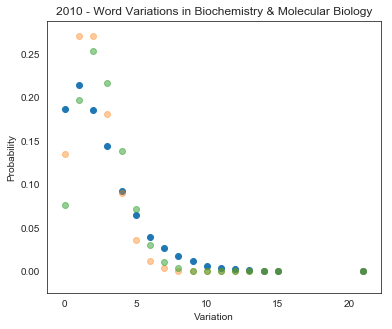

In [13]:
K = 3
year = 2010
f = plt.figure(figsize=(6,5))
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]
variations = [j - K for j in change_in_values]
sum_ = sum(dict(Counter(variations)).values())
from collections import Counter
X = [x+K for x,y in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(111)
ax.scatter(X, Y, alpha=1)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)


##. Fitting the poisson distribution
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

parameters, cov_matrix = curve_fit(poisson, X, Y)
plt.scatter(X, poisson(X, *parameters), alpha=0.4)


y_fit0 = poisson(X, *parameters)
ssq0=((y_fit0 - Y)**2).sum()
print(ssq0)

##. Fitting the distribution by our own values of k and lambda
lam = np.mean(change_in_values)
Y_poiss = list(map(lambda x: poisson(x, lam), X))
plt.scatter(X, Y_poiss, alpha=0.5)

ssq1 = ((np.array(Y_poiss) - np.array(Y))**2).sum()
print(ssq1)

In [14]:
# fitting using stats poisson

# https://stackoverflow.com/questions/24452594/fitting-a-poisson-distribution-to-data-in-statsmodels
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson, Logit

poissonModel = Poisson(change_in_values,np.ones_like(change_in_values))
poissonRes = poissonModel.fit()
print(poissonRes.summary())

Optimization terminated successfully.
         Current function value: 2.268145
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                 3153
Model:                        Poisson   Df Residuals:                     3152
Method:                           MLE   Df Model:                            0
Date:                Wed, 12 Jun 2019   Pseudo R-squ.:                   0.000
Time:                        14:49:20   Log-Likelihood:                -7151.5
converged:                       True   LL-Null:                       -7151.5
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9424      0.011     84.769      0.000       0.921       0.964


In [30]:
lambda_ = np.exp(poissonRes.params[0])
lambda_

2.5661274976213133

In [31]:
poissonModel.loglike(poissonRes.params)

-7151.461171388913

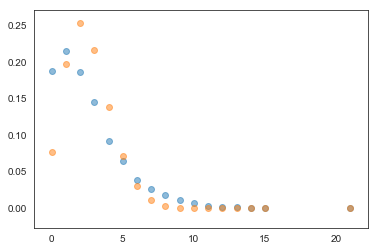

In [32]:
Y_poiss = list(map(lambda x: poisson(x, lambda_), X))

plt.scatter(X, Y, alpha=0.5)
plt.scatter(X, Y_poiss, alpha=0.5)

In [33]:
# https://stackoverflow.com/questions/23816522/fitting-negative-binomial-in-python
nb = NegativeBinomial(change_in_values,np.ones_like(change_in_values))
negBinomialRes = nb.fit()
print(negBinomialRes.summary())

Optimization terminated successfully.
         Current function value: 2.074493
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                 3153
Model:               NegativeBinomial   Df Residuals:                     3152
Method:                           MLE   Df Model:                            0
Date:                Wed, 12 Jun 2019   Pseudo R-squ.:               9.650e-12
Time:                        00:30:39   Log-Likelihood:                -6540.9
converged:                       True   LL-Null:                       -6540.9
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9424      0.017     56.7

In [34]:
nb.loglike(negBinomialRes.params)

-6540.875515121359

_Ratio of log likelihood_

In [28]:
poisson_loglikelihood = poissonModel.loglike(res.params)
neg_binomial_loglikelihood = nb.loglike(res.params)

# Ratio of log likelihood
poisson_loglikelihood

ValueError: shapes (3153,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)